<b><FONT size="9" color='#884846'>Projet Scoring</FONT>

<b><FONT size="4" color='#595949'>Fancello Marie Clara, Germini Eva, Gutfreund Eloise

<b><FONT size="5" color='#884846'>Premiers traitements </FONT>


<b><FONT size="4" color='#858846'>Installation des librairies</FONT>

In [43]:
# Installation de skmine 
# Etape 1: Dans le terminal 
# !pip install https://github.com/scikit-mine/scikit-mine.git
# Etape 2: Proceder a l'installation 

# Installation de scikit-mine
# !pip install -U scikit-mine

# Installation de association_metrics
#!pip install association_metrics

# Installation de researchpy
# !pip install researchpy

<b><FONT size="4" color='#858846'>Importation des librairies</FONT>

In [1]:
from math import log
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pour calculer les correlations de Cramer : 
from scipy.stats import chi2_contingency

# Pour Discretizer :
from skmine.preprocessing import MDLPDiscretizer

# Pour les graphiques :
import seaborn as sns
from matplotlib import pyplot as plt 

# Pour la corrélation entre les catégorielles :
import researchpy

# Pour le split de la base :
from sklearn.model_selection import train_test_split

# Correlation de Cramer : 
import association_metrics as am

# Pour le vif :
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Pour le modèle GLM : 
import statsmodels.api as sm

# Pour le modèle logit  : 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import scipy.stats as stat

# Pour le modèle random forest : 
from sklearn.ensemble import RandomForestClassifier

# Pour les prédictions du modèle : 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

<b><FONT size="4" color='#858846'>Lecture et premier apercu de la base de donnees</FONT>

In [2]:
# Importation de la base 
df=pd.read_csv('hmeq.csv')

In [3]:
# Dimension de la dataframe
print("La dimension de la base de donnees est: ", df.shape)

La dimension de la base de donnees est:  (5960, 13)


In [4]:
#Observation des cinq premieres lignes du dataframe 
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
# Informations sur les variables du dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
# Information sur les doublons
df_no_duplicates=df.drop_duplicates()
print("Il y a " + str(len(df)-len(df_no_duplicates)) + " doublon.")

Il y a 0 doublon.


In [7]:
# Liste des variables numeriques 
var_num=["LOAN","MORTDUE","VALUE","DEROG","DELINQ","CLAGE","NINQ","CLNO","DEBTINC","YOJ"]

# Liste des variables categorielles 
var_cat=["REASON","JOB"]

<b><FONT size="4" color='#884846'>Separation du Train et du Test</FONT>

In [8]:
# Variable d'output 
y="BAD"

# Matrice design 
X=var_num+var_cat

Nous prenons 70% de la base de donnees pour la base d'entrainement. 

Les 30% restant seront dans la base test. <br>

L'option random_state sert à fixer le tirage aleatoire des echantillons. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.30, random_state=42)

In [10]:
print("La dimension de la base de donnees contenant les variables explicatives du train est: ", X_train.shape)
print("La dimension de la base de donnees contenant les variables explicatives du test est: ", X_test.shape)

La dimension de la base de donnees contenant les variables explicatives du train est:  (4172, 12)
La dimension de la base de donnees contenant les variables explicatives du test est:  (1788, 12)



<b><FONT size="5" color='#884846'>Premieres statistiques descriptives</FONT>

<b><FONT size="4" color='#858846'> 1. Description de notre variable d'interet </FONT>

In [11]:
# Pourcentage des valeurs manquantes au sein du train 
percent_missing = y_train.isnull().sum() * 100 / len(y_train)
print("Le pourcentage de valeur manquante est de :",percent_missing, " %")

Le pourcentage de valeur manquante est de : 0.0  %


Il n'y pas de valeurs manquantes au sein de y_train. 

In [12]:
# Passage de la variable d'output en catégorielle
y_train1 = y_train.astype(object)

In [13]:
# Statistique descriptive de la variable d'intérêt 
y_train1.describe()

count     4172
unique       2
top          0
freq      3382
Name: BAD, dtype: int64

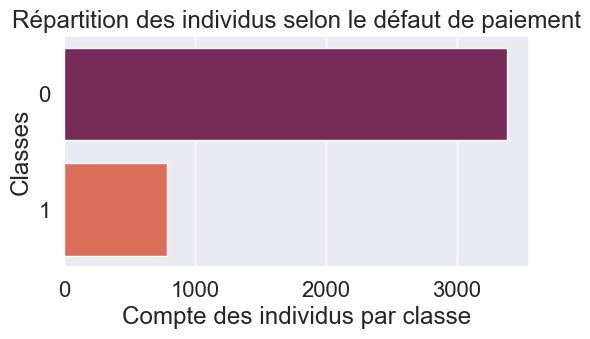

In [14]:
# Bar plot de la variable d'interêt 
sns.set(style="darkgrid", font_scale=1.45) 
plt.figure(figsize=(6,3))
sns.countplot(y=y_train1,palette="rocket")
plt.title("Répartition des individus selon le défaut de paiement")
plt.ylabel("Classes")
plt.xlabel("Compte des individus par classe")
#Si nous voulons sauvegarder le graphique: plt.savefig('repartition_target.png')
plt.show()

<b><FONT size="4" color='#858846'> 2. Description des variables numeriques </FONT>

<b><FONT size="4" color='#002666'> 2.1. Distributions </FONT>

In [15]:
# Statistique descriptive des variables numériques
X_train[var_num].describe()

,LOAN,MORTDUE,VALUE,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,YOJ
count,4172.000000,3818.000000,4104.000000,3683.000000,3775.000000,3966.000000,3826.000000,4028.000000,3305.000000,3836.000000
mean,18661.792905,73971.637169,101888.558957,0.260114,0.417219,180.341964,1.189754,21.299404,33.691051,8.957990
std,11056.280141,44982.728677,57528.951657,0.854234,1.058676,86.480519,1.754042,10.129763,8.008384,7.641045
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499,0.000000
25%,11300.000000,46385.000000,66705.250000,0.000000,0.000000,115.675000,0.000000,15.000000,29.188980,3.000000
50%,16400.000000,65106.500000,89539.500000,0.000000,0.000000,173.665900,1.000000,20.000000,34.760575,7.000000
75%,23300.000000,91488.000000,119521.250000,0.000000,0.000000,232.286621,2.000000,26.000000,38.972487,13.000000
max,89900.000000,399550.000000,855909.000000,10.000000,12.000000,1168.233561,17.000000,71.000000,133.528270,41.000000


<b><FONT size="4" color='#002666'> 2.2. Boxplots </FONT>

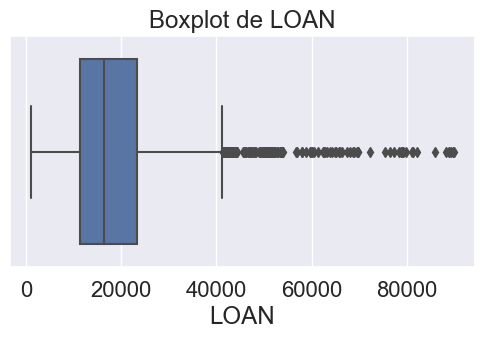

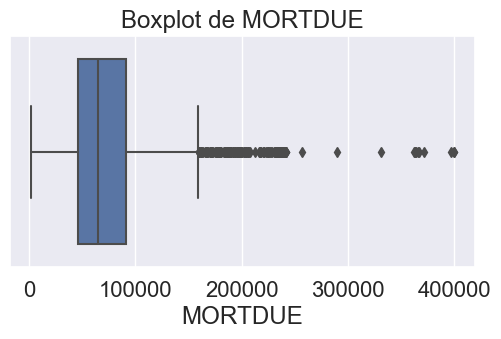

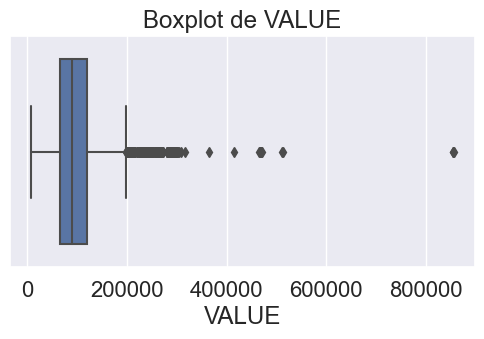

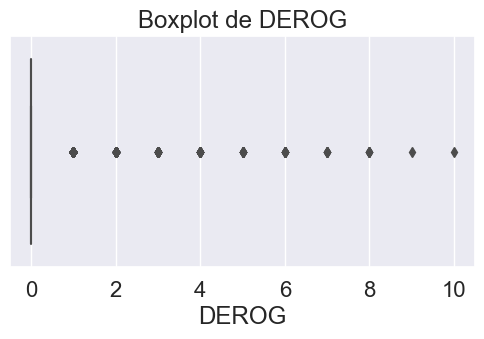

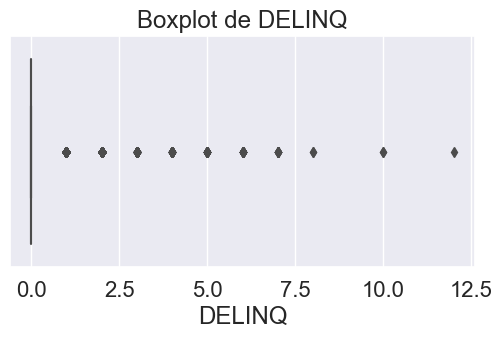

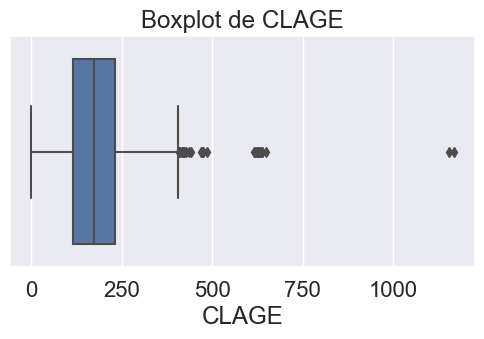

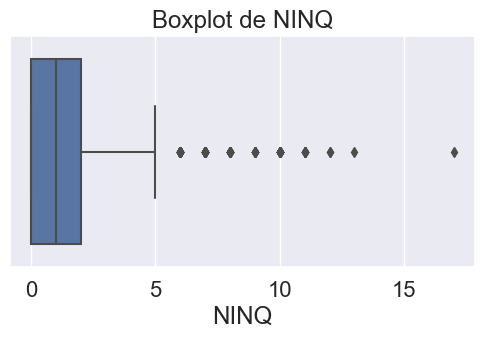

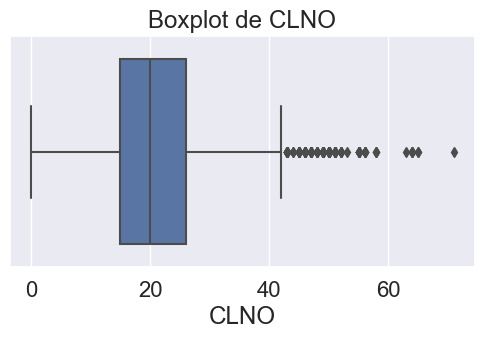

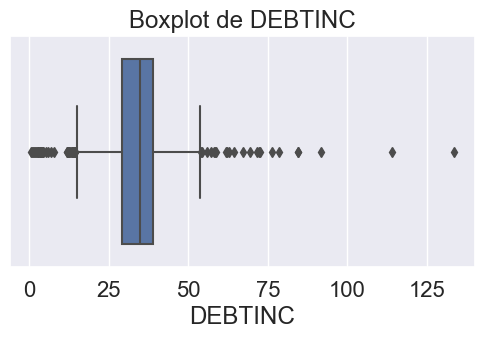

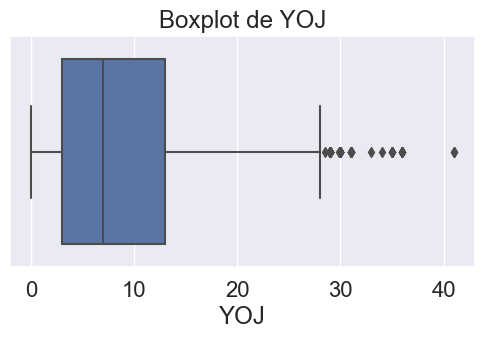

In [16]:
# Boxplot des variables numeriques 
for var in var_num:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=X_train[var]).set_title("Boxplot de " + var)
    #Si nous voulons sauvegarder le graphique: plt.savefig('Boxplot'+var+'.png')
    plt.show()


<b><FONT size="4" color='#002666'> 2.3. Analyse et traitement des valeurs manquantes: </FONT>

In [17]:
# Pourcentage des valeurs manquantes au sein de X_train  
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
missing_value_df_train = pd.DataFrame({'Pourcentage_valeurs_manquantes': percent_missing})
missing_value_df_train.sort_values('Pourcentage_valeurs_manquantes', inplace=True)
print(missing_value_df_train)

         Pourcentage_valeurs_manquantes
LOAN                           0.000000
VALUE                          1.629914
CLNO                           3.451582
REASON                         3.930968
JOB                            4.697987
CLAGE                          4.937680
YOJ                            8.053691
NINQ                           8.293384
MORTDUE                        8.485139
DELINQ                         9.515820
DEROG                         11.720997
DEBTINC                       20.781400


<b><FONT size="4" color='#002666'>  2.4. Traitement des valeurs manquantes </FONT>

In [18]:
# Liste des variables numeriques presentant des valeurs manquantes
var_num_NANs=['CLNO','CLAGE','YOJ','NINQ','DELINQ','DEROG','DEBTINC','MORTDUE','VALUE']

Pour les variables numeriques, nous remplacons les valeurs manquantes par la mediane car toutes ces variables ont des valeurs extrêmes.

In [19]:
for var in var_num_NANs:
    X_train[var].fillna((X_train[var].median()),inplace=True)
    X_test[var].fillna((X_train[var].median()),inplace=True)

In [20]:
# Les NA des variables numeriques ont bien ete imputees par la médiane 
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
missing_value_df_train = pd.DataFrame({'Pourcentage_valeurs_manquantes': percent_missing})
missing_value_df_train.sort_values('Pourcentage_valeurs_manquantes', inplace=True)
print(missing_value_df_train)

         Pourcentage_valeurs_manquantes
LOAN                           0.000000
MORTDUE                        0.000000
VALUE                          0.000000
DEROG                          0.000000
DELINQ                         0.000000
CLAGE                          0.000000
NINQ                           0.000000
CLNO                           0.000000
DEBTINC                        0.000000
YOJ                            0.000000
REASON                         3.930968
JOB                            4.697987


<b><FONT size="4" color='#002666'> 2.5. Analyse des correlations : </FONT>

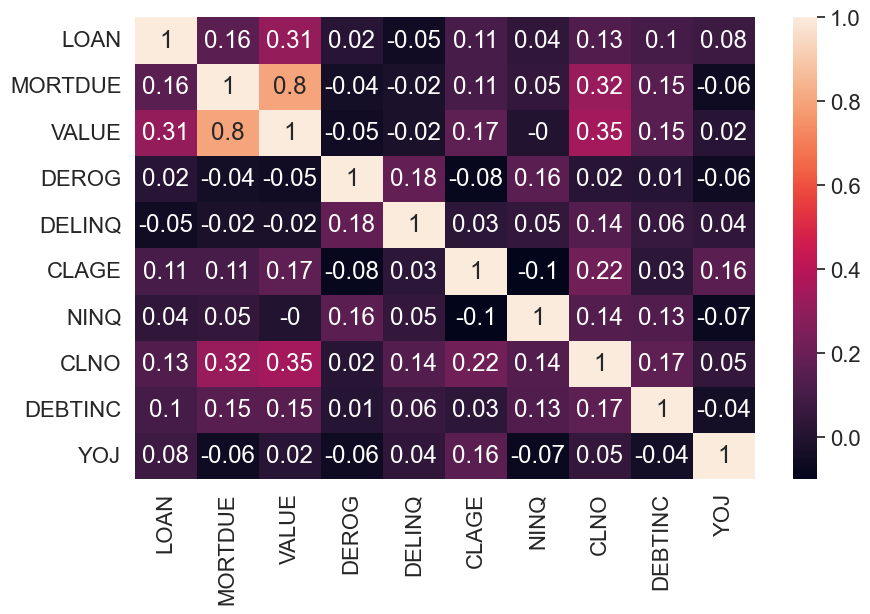

In [21]:
# Matrice des correlations des variables numériques 
corrMatrix = round(X_train[var_num].corr(method="spearman"),2)
plt.figure(figsize=(10,6))
sns.heatmap(corrMatrix, annot=True)
#Si nous voulons sauvegarder le graphique: 
plt.savefig('correlations.png')
plt.show()

Nous constatons que VALUE et MORTDUE sont fortement correlees. Nous decidons de supprimer la variable Value.

In [22]:
# Suppression de la variable VALUE
del(X_train['VALUE'])
del(X_test['VALUE'])
var_num.remove('VALUE')
print(var_num)

['LOAN', 'MORTDUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'YOJ']


<b><FONT size="4" color='#858846'> 3. Description des variables categorielles </FONT>

<b><FONT size="4" color='#002666'> 3.1. Distributions : </FONT>

In [23]:
# Statistiques descriptives des variables catégorielles
X_train[var_cat].describe()

,REASON,JOB
count,4008,3976
unique,2,6
top,DebtCon,Other
freq,2772,1644


<b><FONT size="4" color='#002666'> 3.2. Representations graphiques : </FONT>

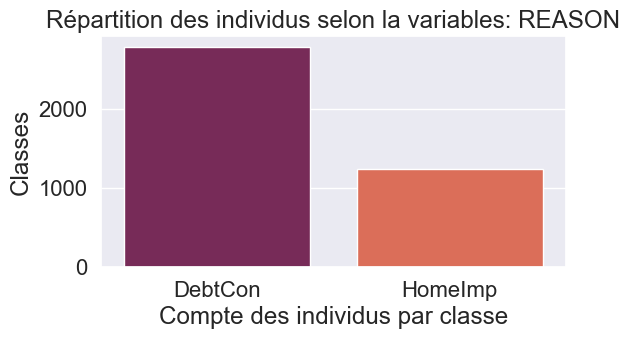

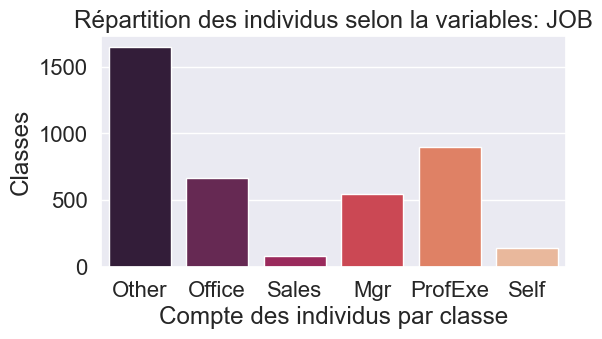

In [24]:
# Matrice des correlations
for var in var_cat:
    sns.set(style="darkgrid", font_scale=1.45) 
    plt.figure(figsize=(6,3))
    sns.countplot(X_train[var], palette="rocket")
    plt.title("Répartition des individus selon la variables: " + var)
    plt.ylabel("Classes")
    plt.xlabel("Compte des individus par classe")
    #Si nous voulons sauvegarder le graphique: plt.savefig('repartition_'+var+'.png')
    plt.show()

<b><FONT size="4" color='#002666'> 3.3. Gestion des valeurs manquantes </FONT>

In [25]:
# Pourcentage de valeurs manquantes pour les variables categorielles
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
missing_value_df_train = pd.DataFrame({'Pourcentage_valeurs_manquantes': percent_missing})
missing_value_df_train.sort_values('Pourcentage_valeurs_manquantes', inplace=True)
print(missing_value_df_train)

         Pourcentage_valeurs_manquantes
LOAN                           0.000000
MORTDUE                        0.000000
DEROG                          0.000000
DELINQ                         0.000000
CLAGE                          0.000000
NINQ                           0.000000
CLNO                           0.000000
DEBTINC                        0.000000
YOJ                            0.000000
REASON                         3.930968
JOB                            4.697987


In [26]:
# Liste des variables categorielles avec des valeurs manquantes 
var_cat_NANs=['JOB', 'REASON']

Pour les variables categorielles, nous créons une categorie nommee Missing.

In [27]:
for var in var_cat_NANs:
    X_train[var].fillna("Missing",inplace=True)
    X_test[var].fillna("Missing",inplace=True)

Nous n'avons plus de valeurs manquantes dans notre base de donnees. 

In [28]:
# Au sein du train 
percent_missing = X_train.isnull().sum() * 100 / len(X_train)
missing_value_df_train = pd.DataFrame({'Pourcentage_valeurs_manquantes': percent_missing})
missing_value_df_train.sort_values('Pourcentage_valeurs_manquantes', inplace=True)
print(missing_value_df_train)

         Pourcentage_valeurs_manquantes
LOAN                                0.0
MORTDUE                             0.0
DEROG                               0.0
DELINQ                              0.0
CLAGE                               0.0
NINQ                                0.0
CLNO                                0.0
DEBTINC                             0.0
YOJ                                 0.0
REASON                              0.0
JOB                                 0.0


<b><FONT size="4" color='#002666'> 3.4. Analyse des correlations </FONT>

In [29]:
# Correlation entre les variables categorielles
contable=researchpy.crosstab(X_train["JOB"],X_train["REASON"], test="chi-square")
contable

(         REASON                      
 REASON  DebtCon HomeImp Missing   All
 JOB                                  
 Mgr         412     121      11   544
 Missing      86      39      71   196
 Office      435     214      20   669
 Other      1126     475      43  1644
 ProfExe     588     293      15   896
 Sales        74       7       0    81
 Self         51      87       4   142
 All        2772    1236     164  4172,
                  Chi-square test   results
 0  Pearson Chi-square ( 12.0) =   680.6322
 1                     p-value =     0.0000
 2                  Cramer's V =     0.2856)

Les variables categorielles ne sont pas fortement correlees.

<b><FONT size="5" color='#884846'>Analyse croisee des variables explicatives et de la variable expliquee </FONT>

<b><FONT size="4" color='#858846'> 1. Distribution des variables numeriques selon la variable d'interet </FONT>

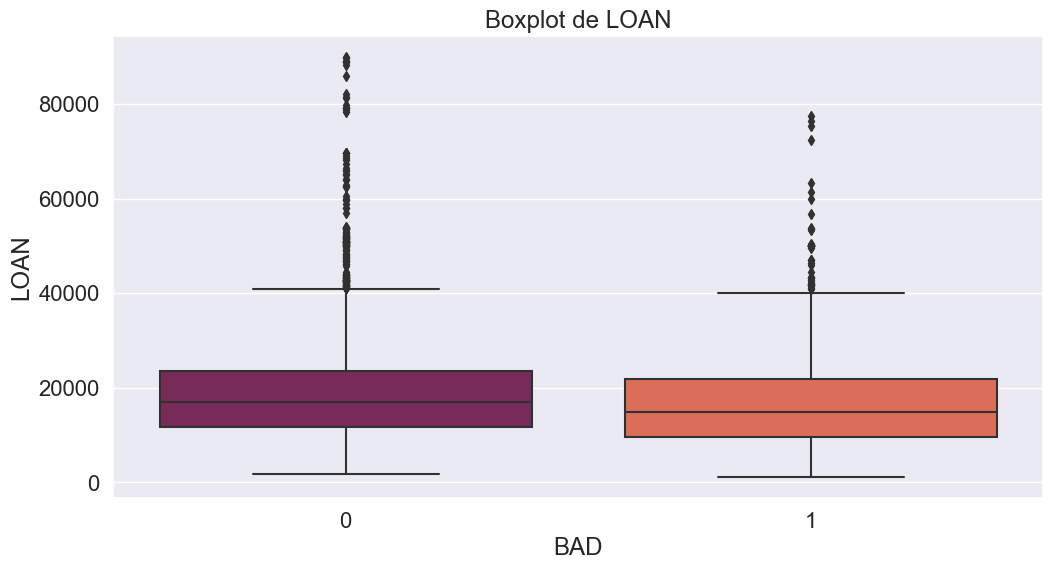

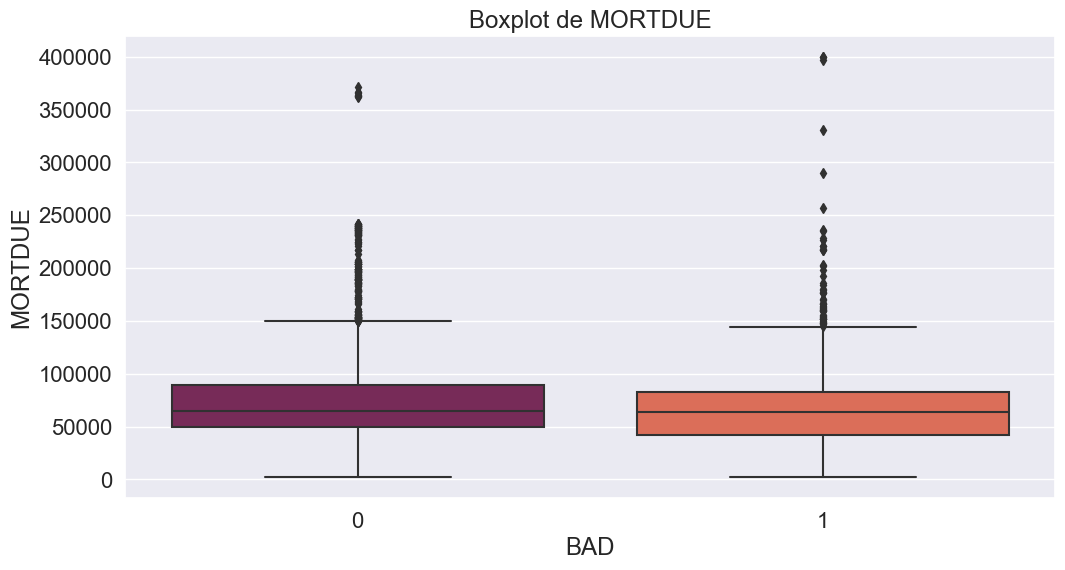

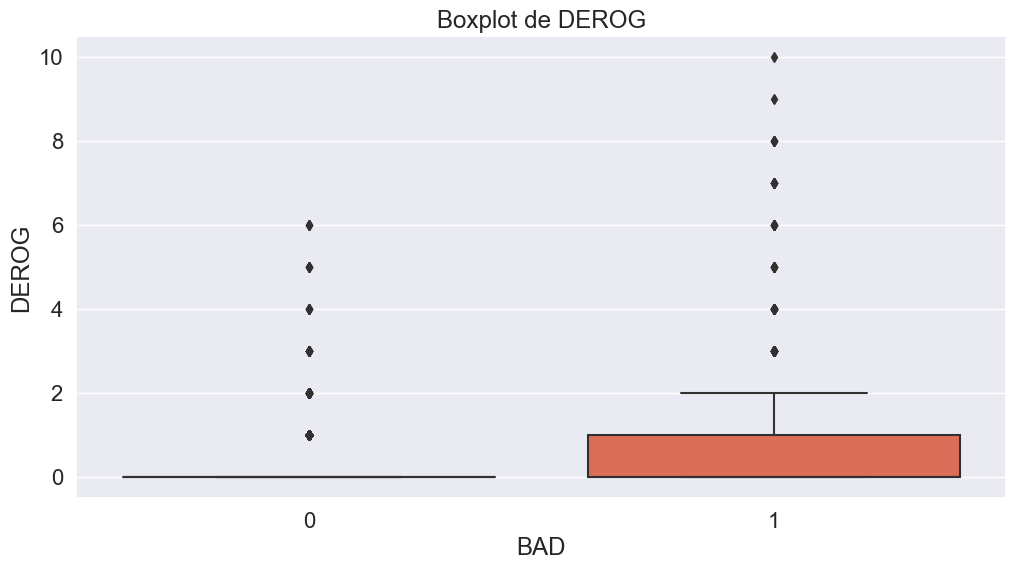

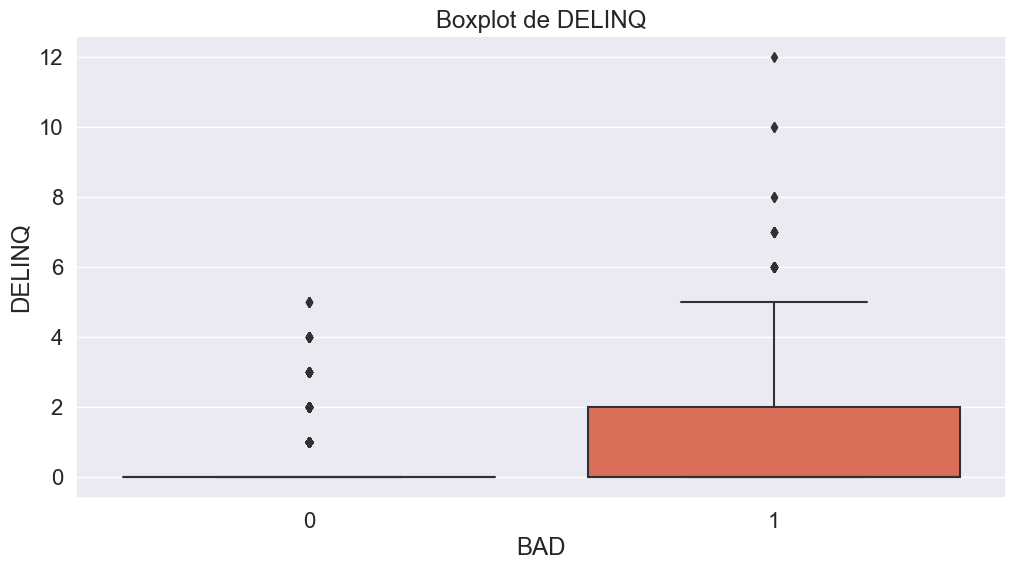

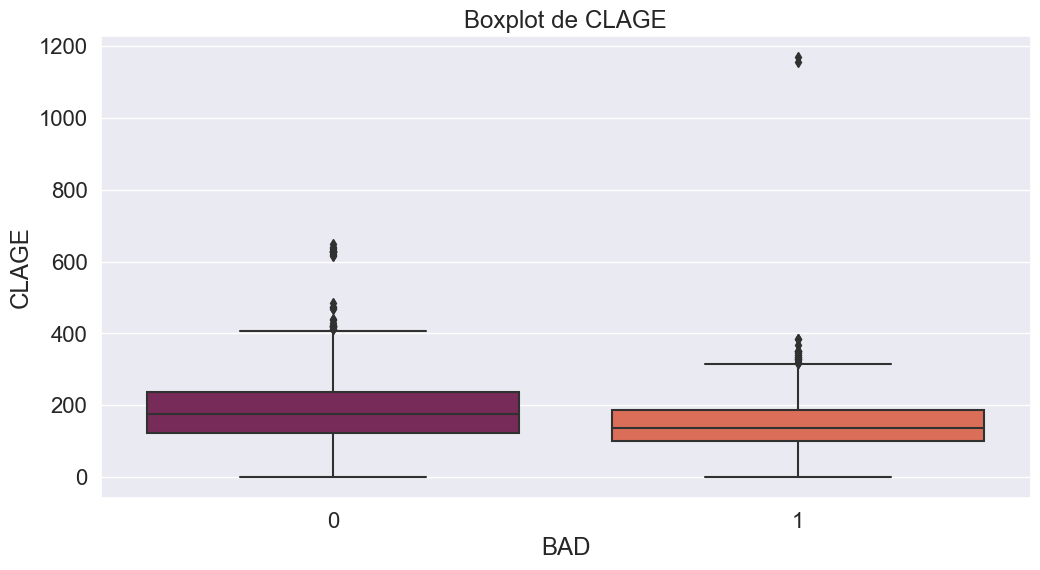

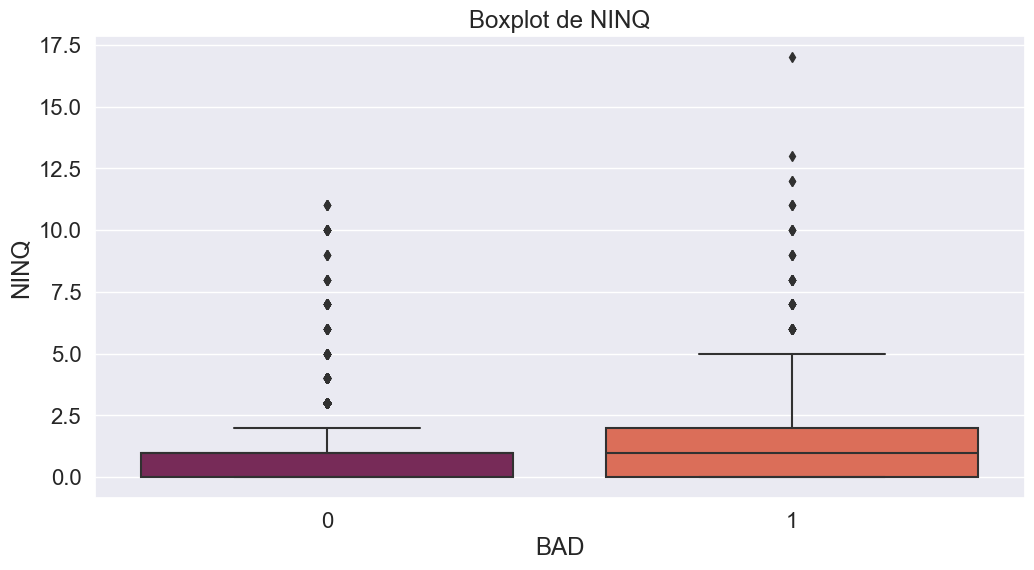

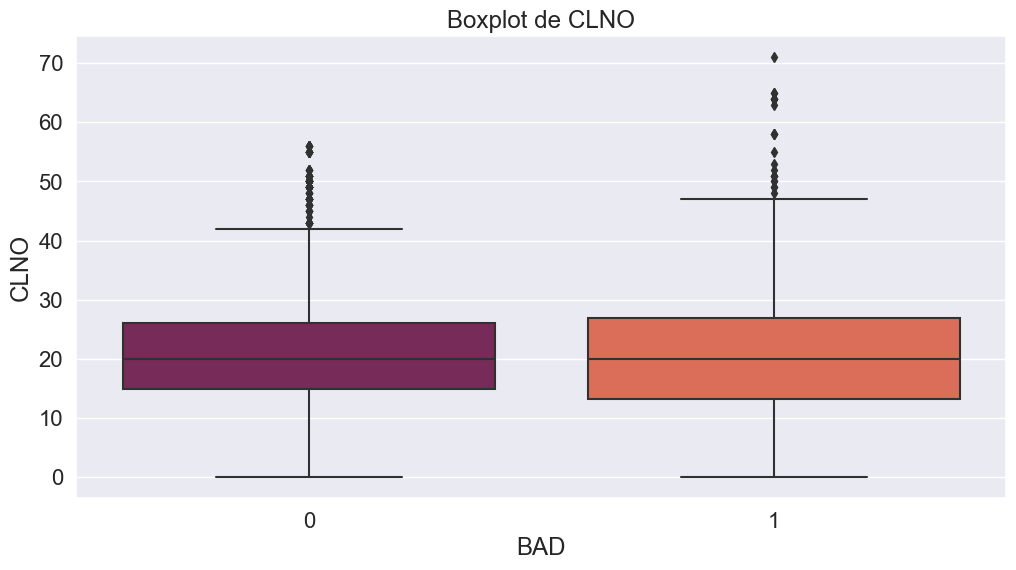

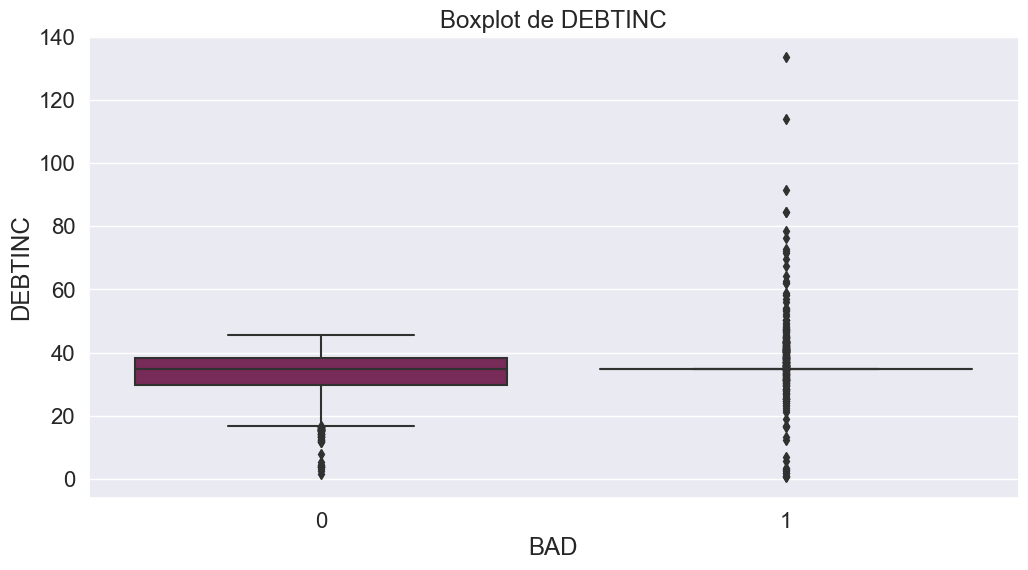

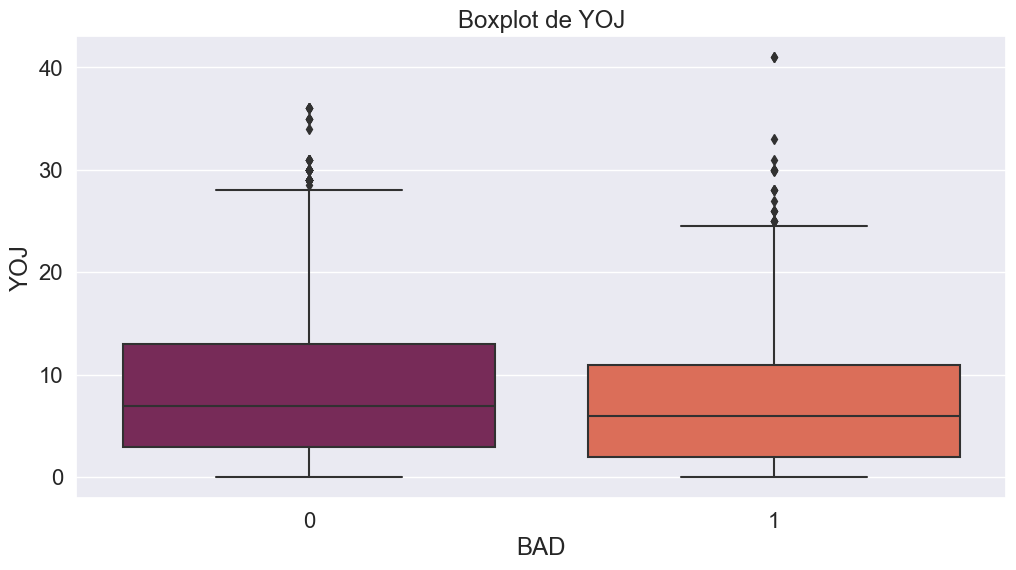

In [30]:
# Boxplot des variables numeriques selon les modalites de la variables "BAD"
for var in var_num:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=y_train, y=X_train[var],palette="rocket").set_title("Boxplot de " + var)
    #Si nous voulons sauvegarder le graphique: plt.savefig('boxplot'+var+'.png')
    plt.show()

<b><FONT size="4" color='#858846'> 2. Distribution des variables categorielles selon la target </FONT>

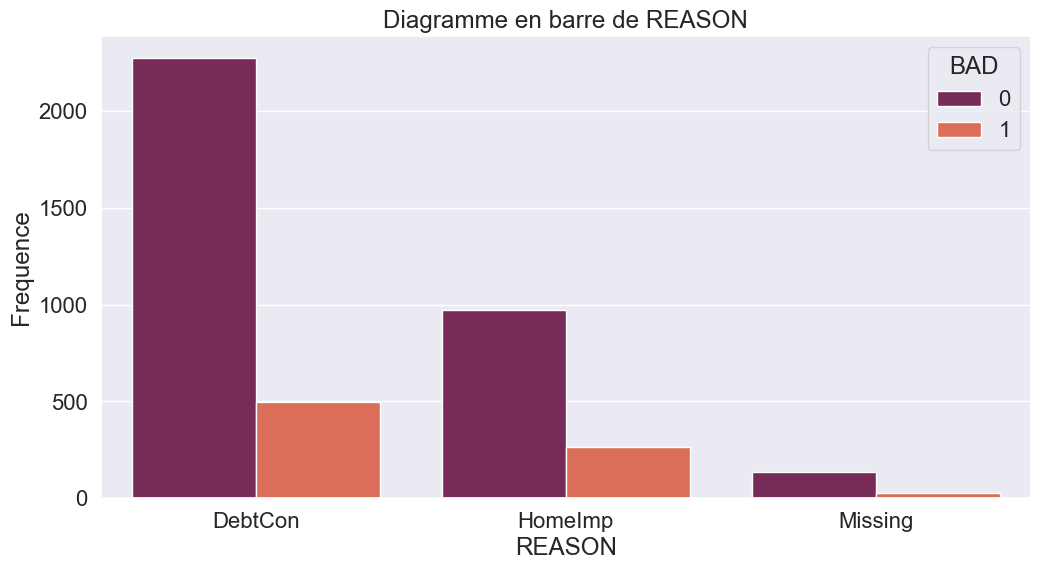

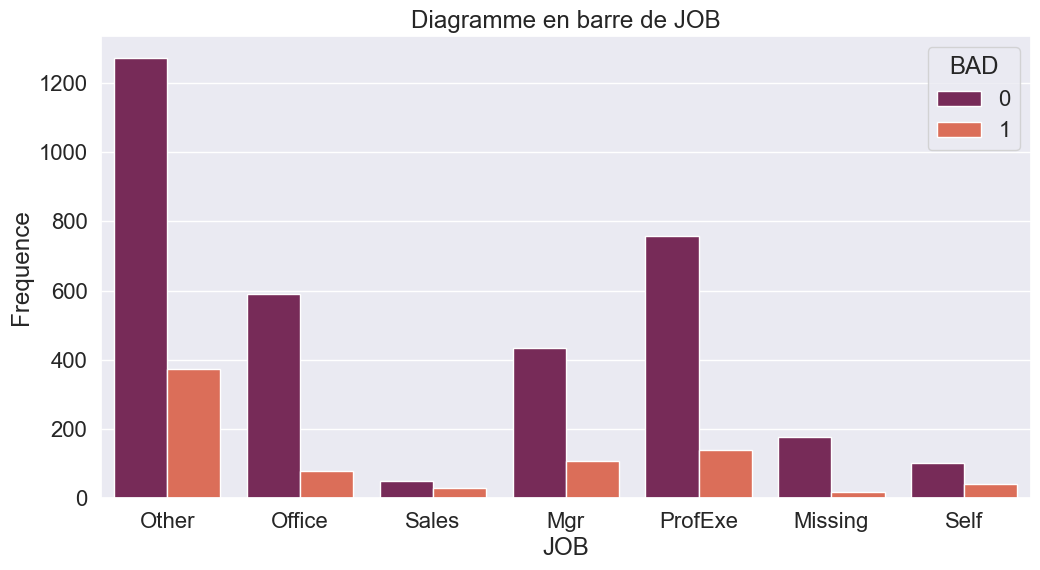

In [31]:
# Diagramme en barre des variables categorielles en fonction de "BAD"
for var in var_cat:
    plt.figure(figsize=(12,6))
    sns.countplot(x=X_train[var],palette='rocket',hue=y_train)
    plt.title("Diagramme en barre de " + var)
    plt.ylabel("Frequence")
    plt.xlabel(var)
    # save plot
    #plt.savefig('histogramme'+var+'.png')
plt.show()

<b><FONT size="5" color='#884846'>Discretisation des variables numeriques </FONT>

Discretisation sur l'échantillon de train : 

In [32]:
# Application de la discretisation
discretizer=MDLPDiscretizer(random_state=100)
discretizer.fit(X_train[var_num], y_train.astype(int))

#calcul cuts points
cuts=discretizer.cut_points_
print("Les cuts points pour chaque variables sont: ", cuts)

#discretize les variables
X_train_num=discretizer.transform(X_train[var_num])

Les cuts points pour chaque variables sont:  {'LOAN': array([ 5100., 15100., 14900.]), 'MORTDUE': array([39007.]), 'DEROG': array([1., 3.]), 'DELINQ': array([1., 3., 5.]), 'CLAGE': array([173.66590016]), 'NINQ': array([2., 4.]), 'CLNO': array([57.,  3.]), 'DEBTINC': array([34.76057541,  3.49997028, 34.62593111, 44.5653271 , 45.9374574 ]), 'YOJ': array([0.9, 0. , 5. ])}


Application de la discretisation l'echantillon de test :

In [33]:
X_test_cat=discretizer.transform(X_test[var_num])

In [34]:
# Concatenation des variables categorielles et des variables numeriques discretisees sur le train
X_train_cat = X_train[['REASON','JOB']].reset_index()
X_train_num['REASON'] = X_train_cat['REASON']
X_train_num['JOB'] = X_train_cat['JOB']
X_train = X_train_num.copy(deep=True)

In [35]:
# Concatenation des variables categorielles et des variables numériques discretisees sur le train
X_test_cat['REASON'] = X_test['REASON']
X_test_cat['JOB'] = X_test['JOB']
X_test= X_test_cat.copy(deep=True)

Analyse du nombre de modalité (0,1) selon les variables discretisees : 

In [36]:
var = var_num+var_cat
for names in var: 
    print(round(pd.crosstab(y_train,X_train[names])*100/len(X_train),2))
    print("\n")

LOAN    0      1      3
BAD                    
0     1.8  22.36  31.57
1     0.5   5.51   8.08


MORTDUE     0      1
BAD                 
0        8.99  46.74
1        2.37  11.72


DEROG      0     1     2
BAD                     
0      52.97  1.89  0.86
1      13.30  0.55  0.24


DELINQ      0     1     2     3
BAD                            
0       51.27  3.16  0.86  0.43
1       12.78  0.96  0.24  0.12


CLAGE      0      1
BAD                
0      29.96  25.77
1       6.47   7.62


NINQ      0     1     2
BAD                    
0     47.89  5.49  2.35
1     12.25  1.08  0.77


CLNO     0      2
BAD              
0     1.15  54.58
1     0.29  13.81


DEBTINC     0      2      3     4     5
BAD                                    
0        0.19  21.43  33.41  0.19  0.50
1        0.07   6.02   7.77  0.05  0.19


YOJ     0      2      3
BAD                    
0    4.55  16.75  34.42
1    0.89   4.72   8.49


REASON  DebtCon  HomeImp  Missing
BAD                              
0 

<b><FONT size="5" color='#884846'> Correlations finales </FONT>

In [37]:
# Transformation de la variable y_train en categorielle
y_train1 = y_train.astype(object)

In [38]:
# Liste des variables 
var_model = var_num+var_cat

In [39]:
# Creation d'une base de donnees avec y (en type object), les variables categorielles et les variables numeriques discretisees 
X_train_2 = X_train.copy(deep=True)
X_train_2['BAD'] = y_train1

In [40]:
def chiffre_string(x):
    if x==0:
        return "A"
    elif x==1:
        return "B"
    elif x==2:
        return "C"
    elif x==3:
        return "D"
    elif x==4:
        return "E"
    elif x==5:
        return "F"
    else :
        return x

In [41]:
for var in var_model:
    X_train_2[var]=X_train_2[var].apply(chiffre_string)

In [42]:
for var in var_model:
    X_train_2[var]=X_train_2[var].astype('category')

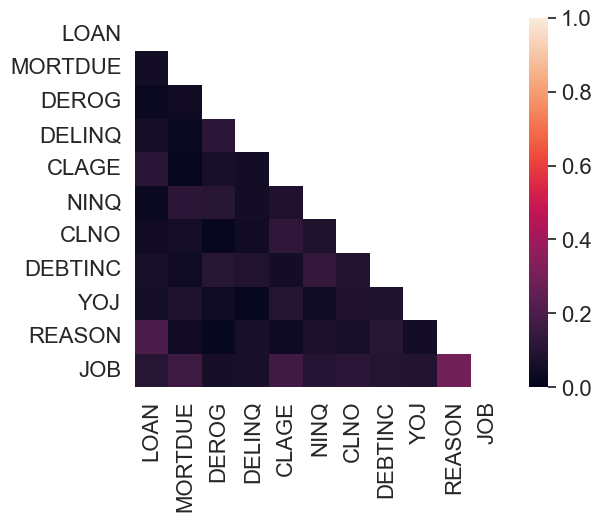

In [43]:
# Correlation de Cramer 
cramersv = am.CramersV(X_train_2)
cr=cramersv.fit()
mask = np.zeros_like(cr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cr, mask=mask,vmin=0., vmax=1, square=True)
plt.show()

In [44]:
# Impression de la correlation de Cramer 
round(cr,2)

,LOAN,MORTDUE,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,YOJ,REASON,JOB
LOAN,1.00,0.05,0.02,0.06,0.11,0.03,0.05,0.06,0.05,0.20,0.10
MORTDUE,0.05,1.00,0.04,0.02,0.01,0.12,0.05,0.04,0.07,0.05,0.16
DEROG,0.02,0.04,1.00,0.11,0.06,0.11,0.02,0.10,0.04,0.02,0.06
DELINQ,0.06,0.02,0.11,1.00,0.05,0.05,0.04,0.09,0.02,0.06,0.06
CLAGE,0.11,0.01,0.06,0.05,1.00,0.09,0.12,0.05,0.09,0.03,0.17
NINQ,0.03,0.12,0.11,0.05,0.09,1.00,0.08,0.14,0.04,0.07,0.10
CLNO,0.05,0.05,0.02,0.04,0.12,0.08,1.00,0.09,0.08,0.06,0.11
DEBTINC,0.06,0.04,0.10,0.09,0.05,0.14,0.09,1.00,0.07,0.10,0.10
YOJ,0.05,0.07,0.04,0.02,0.09,0.04,0.08,0.07,1.00,0.05,0.09
REASON,0.20,0.05,0.02,0.06,0.03,0.07,0.06,0.10,0.05,1.00,0.29


Nous ne supprimons aucune variable : 
- Un coefficient superieur à 0.3 signifie que la correlation entre les variables est forte. 
- Aucune correlation n'est superieure a 0.3.

<b><FONT size="5" color='#884846'> Transformations finales des variables </FONT>

<b><FONT size="4" color='#858846'> Transformation des variables categorielles en variables binaires </FONT>

In [45]:
var_model = var_num+var_cat
X_train= pd.get_dummies(X_train, columns=var_model)
X_test = pd.get_dummies(X_test, columns=var_model) 

<b><FONT size="4" color='#858846'> Suppression des variables pouvant causer la colinearite </FONT>

Nous ne gardons que les variables ayant une majorité de 1. 

In [46]:
to_delete= ['REASON_DebtCon','JOB_Other','LOAN_3','MORTDUE_1', 'DEROG_0', 'DELINQ_0','CLAGE_1','NINQ_0','CLNO_2','DEBTINC_3','YOJ_3']
X_train = X_train.drop(columns=to_delete)
X_test = X_test.drop(columns=to_delete)

In [47]:
X_train.shape

(4172, 26)

# <b><FONT size="4" color='#858846'> Verification de la multicolinearite </FONT>

In [48]:
# Vif pour chaque variable 
def calcul_vif(X):
    vif=pd.DataFrame()
    vif['Variables']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    return(round(vif.sort_values(by=['VIF'],ascending=False),2))

In [49]:
calcul_vif(X_train)

,Variables,VIF
21,JOB_Missing,1.33
19,REASON_Missing,1.25
0,LOAN_0,1.15
10,NINQ_2,1.12
25,JOB_Self,1.10
3,DEROG_1,1.08
11,CLNO_0,1.07
12,DEBTINC_0,1.05
24,JOB_Sales,1.05
4,DEROG_2,1.05


Le VIF evalue si les variables sont colineaire les unes aux autres : 
- Si le VIF est superieur a 10, la multi-colinearite est elevee : la variation semblera plus grande et la variable apparaitra plus influente qu'elle ne l'est en realite.
- Si VIF est plus proche de 1, alors le modele est beaucoup plus robuste, car les variables ne sont pas influencees par la correlation avec d'autres variables.

<b><FONT size="5" color='#884846'> Modele lineaire generalise avec une fonction de lien logit </FONT>

In [50]:
# Replacement des index au sein de l'echantillon train 
y_train_1=y_train.reset_index(drop=True)
X_train_1=X_train.reset_index(drop=True)
y_train_1=list(y_train_1)

# Replacement des index au sein de l'echantillon test
y_test_1=y_test.reset_index(drop=True)
X_test_1=X_test.reset_index(drop=True)
y_test_1=list(y_test_1)

<b><FONT size="4" color='#858846'> Estimation du modele </FONT>

Estimation du modele logit :
- Nous ajoutons une constante au modele. 
- Cette regression n'impose pas de regularisation car nous souhaitons interpreter les parametres sans biais.

In [51]:
# Insertion d'une constante dans la matrice train 
Xs = sm.add_constant(X_train_1)

# Insertion d'une constante dans la matrice test
Xstest = sm.add_constant(X_test_1)

In [52]:
# Définition du modele 
logit_1 = sm.GLM(y_train_1, Xs, family=sm.families.Binomial())
logit_results = logit_1.fit()

Résultats de l'estimation du modele : 

In [53]:
print(logit_results.summary())
params = logit_results.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4172
Model:                            GLM   Df Residuals:                     4145
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1338.8
Date:                Tue, 16 Nov 2021   Deviance:                       2677.6
Time:                        07:54:51   Pearson chi2:                 4.14e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5387      0.135    -18.

Les odds ratio : 

In [54]:
conf = logit_results.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                      5%        95%    Odds Ratio
const           0.060646   0.102827  7.896852e-02
LOAN_0          2.827219   7.113013  4.484422e+00
LOAN_1          1.164284   1.763436  1.432879e+00
MORTDUE_0       1.457784   2.423423  1.879581e+00
DEROG_1         3.232126   7.610873  4.959768e+00
DEROG_2         8.371467  37.432461  1.770211e+01
DELINQ_1        3.611053   6.887607  4.987135e+00
DELINQ_2        8.705732  32.132594  1.672536e+01
DELINQ_3        0.000000        inf  2.445878e+11
CLAGE_0         2.311565   3.541277  2.861100e+00
NINQ_1          1.312695   2.409360  1.778413e+00
NINQ_2          1.923254   4.144070  2.823136e+00
CLNO_0          3.508991  10.469957  6.061269e+00
DEBTINC_0       1.124797  29.461557  5.756585e+00
DEBTINC_2       0.100003   0.176509  1.328583e-01
DEBTINC_4       0.738444  14.448502  3.266407e+00
DEBTINC_5       0.000000        inf  1.253537e+11
YOJ_0           0.331885   0.823898  5.229145e-01
YOJ_2           1.273191   1.922652  1.564578e+00


<b><FONT size="4" color='#858846'> Critere d'information bayesien </FONT>

La log likelihood : 

In [55]:
# La loglikelihood
log_likelihood = logit_1.loglike(logit_results.params)
print("log likelihood : ",log_likelihood)

log likelihood :  -1338.822373763983


Calcule de l'AIC et du BIC 

In [56]:
n = len(y_train_1)
num_params = len(logit_results.params) + 1

# AIC
aic = -2 * log_likelihood + 2 * num_params
print("AIC : ", round(aic,2))

# BIC
bic = -2 * log_likelihood + num_params * log(n)
print("BIC : ", round(bic,2))

AIC :  2733.64
BIC :  2911.06


<b><FONT size="4" color='#858846'> Performance du modele sur l'echantillon test </FONT>

Probabilites predites : 

In [57]:
Prob_1_test = logit_results.predict(Xstest)

In [58]:
Prob_1_test_1 = np.array(Prob_1_test)

Calcule de l'AUC : 

In [59]:
# Creation du classifier sans competence = courbe droite y=x
ns_probs =[0 for _ in range(len(y_test))]

# Le score de l'AUC 
auc=roc_auc_score(y_test,Prob_1_test_1)
auc_ns=roc_auc_score(y_test,ns_probs)
print('AUC: %.2f' % auc)
print('AUC: %.2f' % auc_ns)

AUC: 0.83
AUC: 0.50


Graphique de la ROC curve : 

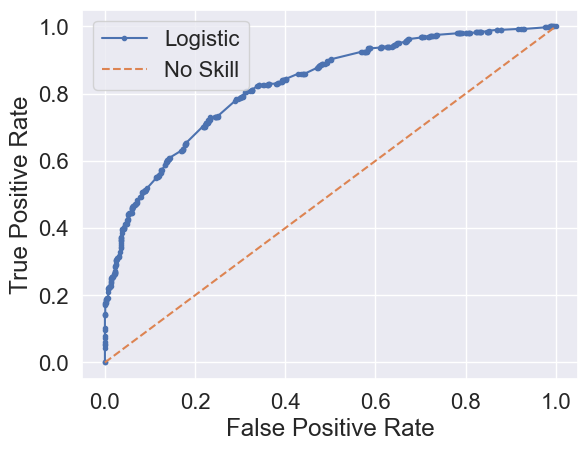

In [60]:
lr_fpr, lr_tpr, _ =roc_curve(y_test,Prob_1_test_1)
ns_fpr, ns_tpr, _ =roc_curve(y_test, ns_probs)

# La courbe ROC
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

# Nom des axes 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Legende
plt.legend()
plt.show()

<b><FONT size="5" color='#884846'> Modele logit avec sklearn </FONT>

Dans cette partie, nous allons utiliser un modele logit avec une etape de cross validation afin de regler les hyperparametres du modele. L'objectif est d'ameliorer les performances sur l'echantillon de test par la penalisation. 

<b><FONT size="4" color='#858846'> Estimation du modele </FONT>

<b><FONT size="4" color='#002666'> Train/Valid </FONT>

Notre cross validation créra 5 reechantillonage: 
- Shuffle: On melange les donnees avant de les diviser en lot 
- On fixe le seed à 42 afin de maintenir le même tirage aleatoire lorsque l'on fait retourner l'algorithme. 

In [61]:
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Modele de regression logistique: 
- Avec constante 
- class_weight='balanced' car le nombre de 1 et de 0 dans la variable 'BAD' sont inegaux

In [62]:
model = LogisticRegression(solver = 'saga')

Création d'un dictionnaire de parametres: 
- On analyse aucune et trois types de pénalites. 
- On fait varier le L1_ratio qui s'applique juste en cas de l'elastic net 
    - L1_ratio = 0 ==> L2
    - L1_ratio = 1 ==> L1
- C est le parametre qui permet de reguler le alpha c'est a dire le parametre de poid pour la regularisation s'appliquant à L1, L2 et elastic net

In [63]:
parametres = { 'class_weight': ['balanced','none'],'penalty': ['none','l1','l2','elasticnet'],  
              'l1_ratio': np.arange(0, 1), 'C': 10. ** np.arange(-5, 5)}

Cross validation du modele par l'utilisation d'une GridSearch
- On entre le modele et le dictionnaire de parametres 
-  n_job fixe le nombre de test que l'algorithme tourne simultannement

In [64]:
clf_cv = GridSearchCV(model,param_grid=parametres, cv=cv, n_jobs=5, scoring='accuracy')

In [65]:
clf_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(solver='saga'), n_jobs=5,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                         'class_weight': ['balanced', 'none'],
                         'l1_ratio': array([0]),
                         'penalty': ['none', 'l1', 'l2', 'elasticnet']},
             scoring='accuracy')

On afficihe les meilleur modele 

In [66]:
print("Le meilleur modele est : ", clf_cv.best_estimator_)
print("L'accuracy est de : ", clf_cv.best_score_)
print("Les meilleurs parametres sont : ", clf_cv.best_params_)

Le meilleur modele est :  LogisticRegression(class_weight='none', l1_ratio=0, penalty='l1', solver='saga')
L'accuracy est de :  0.8684090811183388
Les meilleurs parametres sont :  {'C': 1.0, 'class_weight': 'none', 'l1_ratio': 0, 'penalty': 'l1'}


Estimation du modele logit :

In [67]:
clf_cv = LogisticRegression(C=1.0, class_weight='none', l1_ratio=0, penalty='l1',
                   solver='saga')
model = clf_cv.fit(X_train, y_train)

<b><FONT size="4" color='#858846'> Critere d'information bayesien </FONT>

In [68]:
proba01 = clf_cv.predict_proba(X_train)
proba1 = proba01[:,1]
log_likelihood = np.sum(y_train*np.log(proba1)+(1.0-y_train)*np.log(1.0-proba1))
print("La valeur de la log likehood est de : ", round(log_likelihood,2))

La valeur de la log likehood est de :  -1342.22


In [69]:
n = len(y_train)
num_params = len(model.coef_) + 1

aic =  -2 * log_likelihood + 2 * num_params
print("AIC : ", round(aic,2))
bic = -2 * log_likelihood + num_params * log(n)
print("BIC : ", round(bic,2))

AIC :  2688.44
BIC :  2701.11


<b><FONT size="4" color='#858846'> Performance du modele sur l'echantillon test </FONT>

On applique le modele sur la partie test 

In [70]:
Prob_test=clf_cv.predict_proba(X_test)

In [71]:
Prob_1_test= Prob_test[:, 1]

Calcule de l'AUC : 

In [72]:
# Creation du classifier sans competence = courbe droite y=x
ns_probs =[0 for _ in range(len(y_test))]

# Le score de l'AUC 
auc=roc_auc_score(y_test,Prob_1_test)
auc_ns=roc_auc_score(y_test,ns_probs)
print('AUC: %.2f' % auc)
print('AUC: %.2f' % auc_ns)

AUC: 0.83
AUC: 0.50


Graphique de la ROC curve :

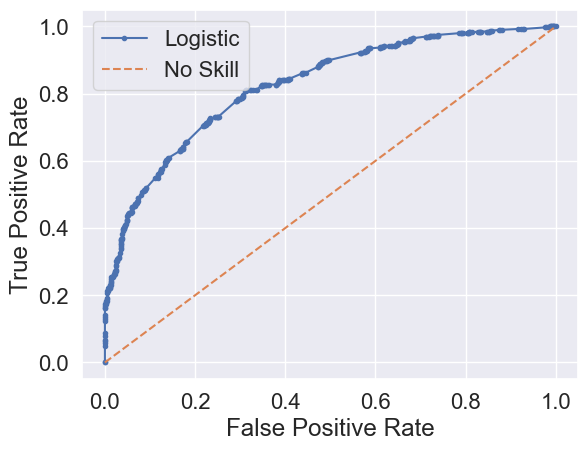

In [73]:
# Le calcule de la courbe ROC
lr_fpr, lr_tpr, _ =roc_curve(y_test,Prob_1_test)
ns_fpr, ns_tpr, _ =roc_curve(y_test, ns_probs)

# La courbe ROC
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

# Nom des axes 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Legende
plt.legend()
plt.show()

<b><FONT size="5" color='#884846'> Random Forest </FONT>

<b><FONT size="4" color='#858846'> Estimation du modele </FONT>

In [74]:
model_RF=RandomForestClassifier(class_weight='balanced')

In [75]:
parametres = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [76]:
# Cross-validation for model selection
clf_rf_cv = GridSearchCV(model_RF,param_grid=parametres, cv=cv, n_jobs=5,  scoring='accuracy')

In [77]:
clf_rf_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]},
             scoring='accuracy')

In [78]:
print("Le meilleur modele est : ", clf_rf_cv.best_estimator_)
print("L'accuracy est de : ", clf_rf_cv.best_score_)
print("Les meilleurs parametres sont : ", clf_rf_cv.best_params_)

Le meilleur modele est :  RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=1400)
L'accuracy est de :  0.8535490170737662
Les meilleurs parametres sont :  {'bootstrap': True, 'max_depth': 20, 'n_estimators': 1400}


<b><FONT size="4" color='#858846'> Performance du modele sur l'echantillon test </FONT>

On applique le modele sur la partie test 

In [79]:
Prob_test2=clf_rf_cv.predict_proba(X_test)
Prob_1_test2= Prob_test2[:, 1]

Calcule de l'AUC : 

In [80]:
# Creation du classifier sans competence 
ns_probs =[0 for _ in range(len(y_test))]

# Le score de l'AUC
auc=roc_auc_score(y_test,Prob_1_test2)
auc_ns=roc_auc_score(y_test,ns_probs)
print('AUC: %.2f' % auc)
print('AUC: %.2f' % auc_ns)

AUC: 0.79
AUC: 0.50


Graphique de l'AUC :

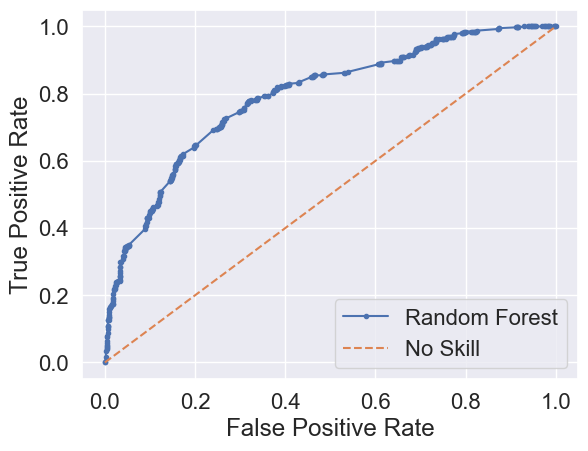

In [81]:
# Le calcule de la courbe ROC
lr_fpr, lr_tpr, _ =roc_curve(y_test,Prob_1_test2)
ns_fpr, ns_tpr, _ =roc_curve(y_test, ns_probs)

# La courbe ROC
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

#Nom des axes 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Legende
plt.legend()
plt.show()